In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))
suppressMessages(library(SeuratDisk))
suppressMessages(library(SingleCellExperiment))
suppressMessages(library(destiny))

In [2]:
obj <- readRDS("../data/mouse_timecourse_snRNA/filename_mouse_subclusters.rds")
obj

class: SingleCellExperiment 
dim: 21340 37424 
metadata(3): hvg leiden1.0_colors sample_colors
assays(1): X
rownames(21340): Xkr4 Gm1992 ... CAAA01147332.1 AC149090.1
rowData names(14): gene_ids feature_types ... variances variances_norm
colnames(37424): AAACCCAAGGCTCTCG-1-0 AAACCCAAGTAACCTC-1-0 ...
  TTTGTTGTCTGTCGCT-1-3 TTTGTTGTCTTTACAC-1-3
colData names(17): n_gene n_umi ... leiden0.1 leiden0.3
reducedDimNames(2): X_pca_harmony X_umap
mainExpName: NULL
altExpNames(0):

In [3]:
## construct seurat object
counts <- obj@assays@data$X
meta.data <- as.data.frame(colData(obj))

In [4]:
## change mouse gene to human
rownames(counts) <- toupper(rownames(counts))

In [5]:
obj.mouse <- CreateSeuratObject(counts = counts,
                               meta.data = meta.data)

In [6]:
head(rownames(obj.mouse))

[1] "XKR4"    "GM1992"  "GM19938" "RP1"     "SOX17"   "MRPL15"

In [7]:
## add harmony and umap
embedding.harmony <- reducedDims(obj)$X_pca_harmony
embedding.umap <- reducedDims(obj)$X_umap

colnames(embedding.harmony) <- paste0("Harmony_", 1:ncol(embedding.harmony))
colnames(embedding.umap) <- paste0("UMAP_", 1:ncol(embedding.umap))

In [8]:
obj.mouse[['harmony']] <- CreateDimReducObject(embeddings = as.matrix(embedding.harmony))
obj.mouse[['umap']] <- CreateDimReducObject(embeddings = as.matrix(embedding.umap))

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“No assay specified, setting assay as RNA by default.”


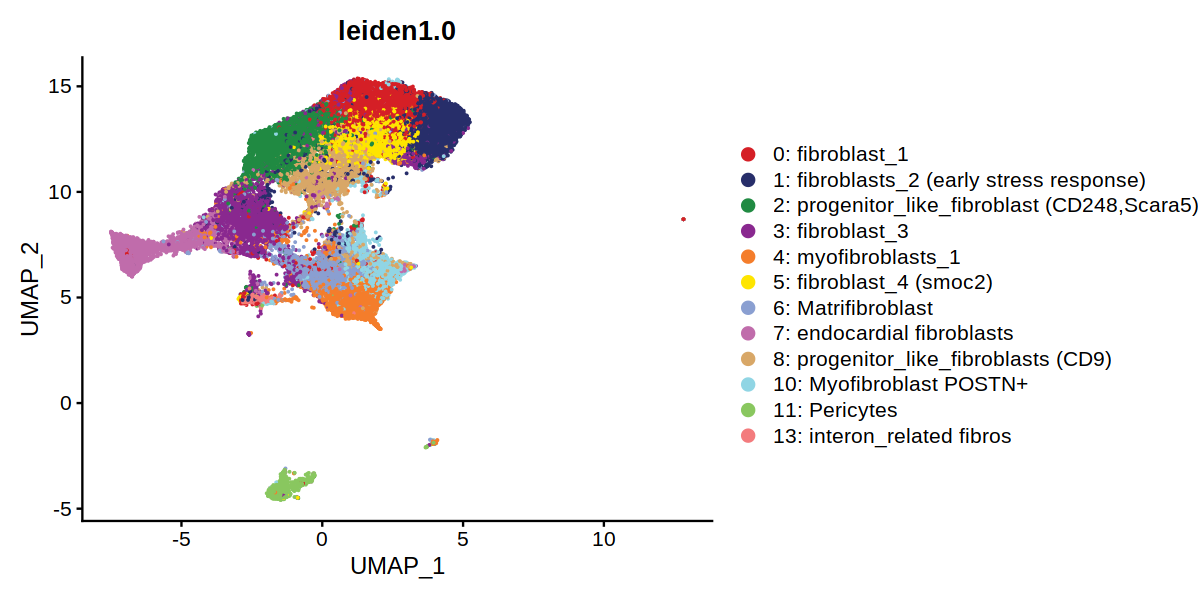

In [9]:
options(repr.plot.height = 5, repr.plot.width = 10)
cols <- ArchR::paletteDiscrete(unique(obj.mouse@meta.data[, "leiden1.0"]))

DimPlot(obj.mouse, reduction = "umap", group.by = "leiden1.0", cols = cols)

In [10]:
Idents(obj.mouse) <- "leiden1.0"

obj.mouse.sub <- subset(obj.mouse, idents = c("7: endocardial fibroblasts",
                                              "11: Pericytes",
                                              "13: interon_related fibros"), invert = TRUE)

Idents(obj.mouse.sub) <- "leiden0.3"

obj.mouse.sub <- subset(obj.mouse.sub, idents = c('7'), 
                        invert = TRUE)

In [11]:
obj.mouse.sub <- RunUMAP(obj.mouse.sub, reduction = "harmony",
                        reduction.name = "umap_harmony",
                        dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message:
“Cannot add objects with duplicate keys (offending key: UMAP_), setting key to 'umap_harmony_'”


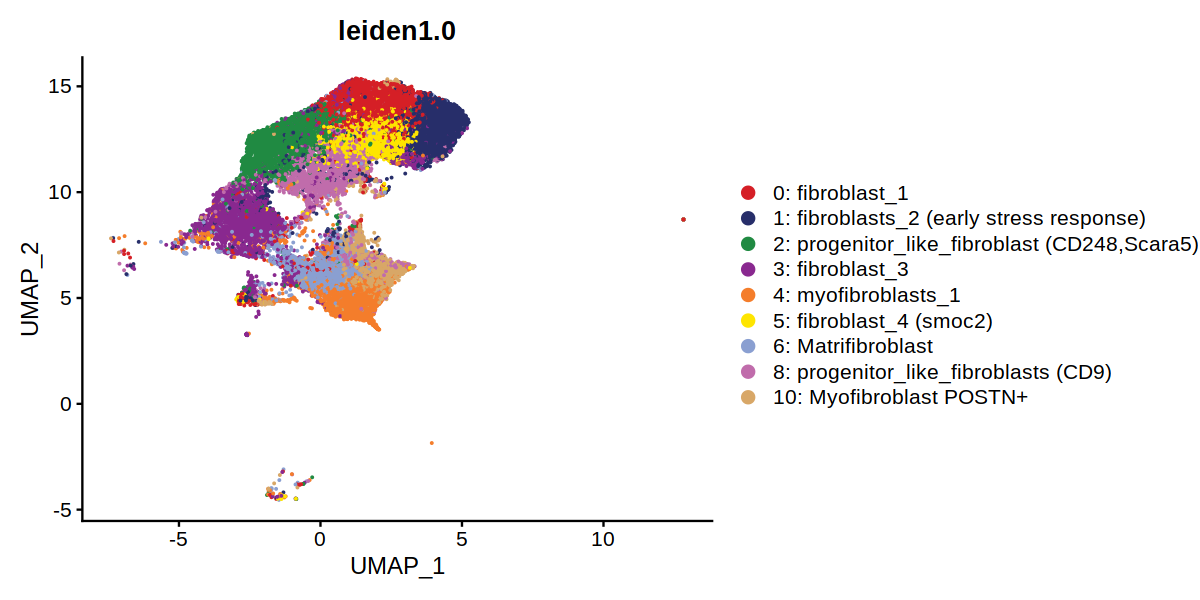

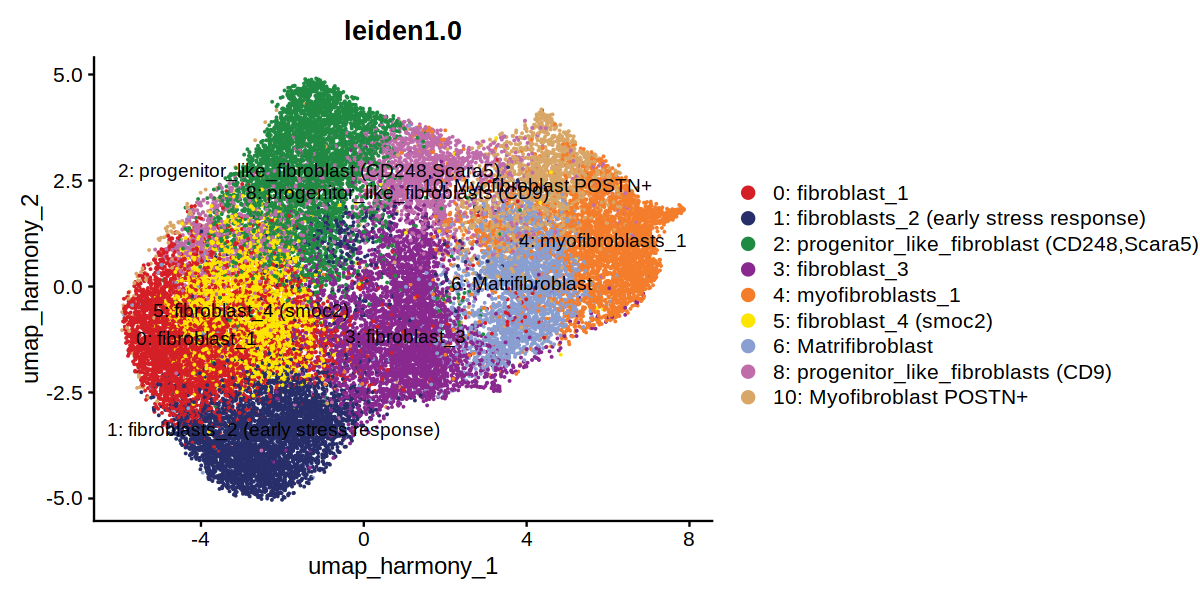

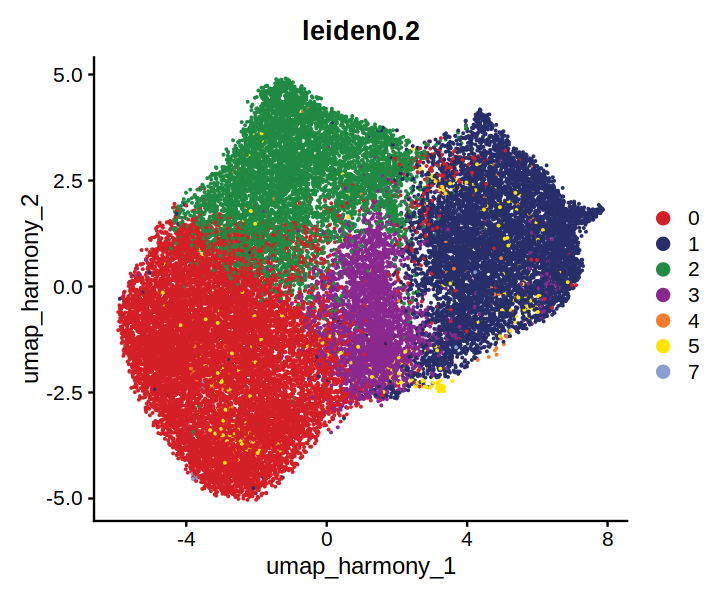

In [12]:
options(repr.plot.height = 5, repr.plot.width = 10)
cols <- ArchR::paletteDiscrete(unique(obj.mouse.sub@meta.data[, "leiden1.0"]))

DimPlot(obj.mouse.sub, reduction = "umap", group.by = "leiden1.0",
       cols = cols)
DimPlot(obj.mouse.sub, reduction = "umap_harmony", group.by = "leiden1.0",
       label = TRUE, cols = cols)

options(repr.plot.height = 5, repr.plot.width = 6)
cols <- ArchR::paletteDiscrete(unique(obj.mouse.sub@meta.data[, "leiden0.2"]))

DimPlot(obj.mouse.sub, reduction = "umap_harmony", group.by = "leiden0.2",
       label = FALSE, cols = cols)

In [13]:
coembed <- readRDS('../data/coembed/coembed.annotation.Rds')

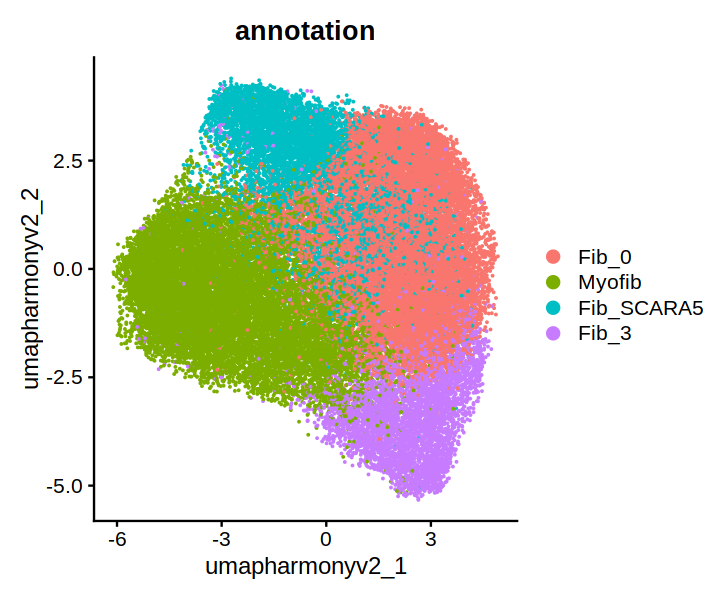

In [14]:
DimPlot(coembed, reduction = "umap_harmony_v2", group.by = "annotation")

In [15]:
obj.mouse.sub <- obj.mouse.sub %>% 
        NormalizeData() %>%
        FindVariableFeatures() %>%
        ScaleData()

Centering and scaling data matrix



In [16]:
gene.use <- intersect(rownames(obj.mouse.sub),
                     rownames(coembed))

length(gene.use)

[1] 14010

In [17]:
## integration
transfer.anchors <- FindTransferAnchors(reference = coembed,
                                        query = obj.mouse.sub,
                                        features = gene.use,
                                        reference.assay = "RNA",
                                        query.assay = "RNA",
                                        reduction = "cca")

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 80949 anchors

Filtering anchors



In [ ]:
celltype.predictions <- TransferData(anchorset = transfer.anchors, 
                                     refdata = coembed$annotation,
                                     weight.reduction = obj.mouse.sub[["harmony"]], 
                                     dims = 1:30)

obj.mouse.sub <- AddMetaData(obj.mouse.sub, metadata = celltype.predictions)

In [ ]:
p1 <- DimPlot(obj.mouse.sub, reduction = "umap_harmony", group.by = "leiden0.2",
             raster = TRUE, size = 0.1, label = FALSE) +
    #scale_color_manual(values = cols) +
    ggtitle("annotated")
    
p2 <- DimPlot(obj.mouse.sub, reduction = "umap_harmony", group.by = "predicted.id",
             size = 0.1, raster = TRUE) +
    #scale_color_manual(values = cols) +
    ggtitle("predicted")

options(repr.plot.height = 5, repr.plot.width = 15)

p1 + p2

In [ ]:
cM <- confusionMatrix(obj.mouse.sub$`leiden0.2`, obj.mouse.sub$predicted.id)
cM <- cM / Matrix::rowSums(cM)

In [ ]:
options(repr.plot.height = 5, repr.plot.width = 6)

suppressMessages(library(ComplexHeatmap))

p <- Heatmap(as.matrix(cM),
             name = "Proportion",
             cluster_columns = FALSE,
             cluster_rows = TRUE,
             clustering_method_rows = "ward.D2",
             clustering_method_columns = "ward.D2",
             clustering_distance_rows = "pearson",
             clustering_distance_columns = "pearson",
             rect_gp = gpar(col = "black", lwd = 0.5),
            col = paletteContinuous("whiteBlue"))

p

In [ ]:
## add annotation
new.cluster.ids <- c("0" = "Fib_0",
               "1" = "Myofib",
               "2" = "Fib_SCARA5",
               "3" = "Fib_0",
                    "4" = "Fib_0",
                    "5" = "Fib_0",
                    "7" = "Fib_0")

Idents(obj.mouse.sub) <- "leiden0.2"

obj.mouse.sub <- RenameIdents(obj.mouse.sub, new.cluster.ids)
obj.mouse.sub$annotation <- Idents(obj.mouse.sub)

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 8)

p1 <- DimPlot(obj.mouse.sub, reduction = "umap_harmony", group.by = "annotation",
             raster = TRUE, size = 0.1, label = FALSE) +
    #scale_color_manual(values = cols) +
    ggtitle("annotated")

p1

In [ ]:
df_plot <- obj.mouse.sub@meta.data %>%
    as.data.frame() %>%
            group_by(condition, annotation) %>%
            summarise(counts = n()) %>%
            mutate(proportion = counts / sum(counts))

df_plot$condition <- factor(df_plot$condition, levels = c("sham", "day_4",
                                                         "day_7a", "day_14"))


p <- ggplot(data = df_plot, aes(x = condition, y = proportion, group = annotation,
                               color = annotation)) +
    geom_point() + 
    geom_line() + theme_cowplot() +
    xlab("") +
    theme(legend.title = element_blank())


options(repr.plot.height = 4, repr.plot.width = 6)

print(p)

In [ ]:
saveRDS(obj.mouse.sub, 
        file = "../data/mouse_timecourse_snRNA/mouse_aggregation_v2_subclustered.cleaned.annotation.Rds")

In [ ]:
sessionInfo()